In [1]:
## Set file date name for use.
filedate = 'Jan162019'

In [2]:
## Bring in needed mod, pandas
import pandas as pd, numpy as np

## Write ftn for median filtering
def median_filter(Y,Kernal,padtype=None,recursive=False):
    window = int((Kernal-1)/2)
    Y = np.array(Y)
    assert len(Y[~np.isnan(Y)]) == len(Y)
    if padtype is None:
        rb = np.ones(window)*Y[0]
        re = np.ones(window)*Y[-1]
    elif padtype is 'Zero':
        rb = np.zeros(window)
        re = np.zeros(window)
    elif padtype is 'Ref':
        rb = list(Y[0] - Y[::-1] + Y[0])[-(window+1):-1]
        re = list(Y[-1] - Y[::-1] + Y[-1])[1:(window+1)]
    else:
        rb = np.zeros(window)
        re = np.ones(window)*Y[-1]
    pry = np.concatenate([rb,Y,re])
    if recursive:
        for i in np.arange(window,len(pry)-window):
            pry[i] = np.median(pry[i-window:i+window+1])
        my = pry[window:-window]
    else:
        my = np.array([np.median(pry[i-window:i+window+1]) for i in np.arange(window,len(pry)-window)])
    return my

In [3]:
## Set file path name, from basic filtering. Should have basic.csv as the end
file_path = '../FILES/Tecan_qtlruns_%s_curated.csv'%(filedate)

In [4]:
## Bring in data
tecan = pd.read_csv(file_path,index_col=0)

In [5]:
## Get column names
colnames = tecan.columns.tolist()

In [6]:
## Get the first time pt index
zero_ix = colnames.index('0s')

In [7]:
## Seperate columns
infos = colnames[:zero_ix]
timepts = colnames[zero_ix:]

In [8]:
## Set the first two timepoints to zero
tecan.loc[:,timepts[:4]] = 0

In [9]:
## Check work
assert timepts[0] == '0s'

In [10]:
test = tecan[(tecan.temp==30) & (tecan.amphB==0.0)]

In [11]:
timex = np.array([int(a[:-1])/(60**2) for a in timepts])

In [12]:
## Bring in matplot lib
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
## Make the baseline dataframe, this is the first hour and a 15min, post the first half hour
baselinedf = tecan[timepts[2:7]].copy()

In [14]:
tecan.strain.unique()[:10]

array(['SS-A837', 'SS-B307', 'SS-B308', 'SS-B310', 'SS-B311', 'SS-B312',
       'SS-B313', 'SS-B314', 'SS-B315', 'SS-B316'], dtype=object)

In [15]:
seg  = 'SS-B307'
_431 = test[(test.strain==seg)][timepts].values

In [16]:
K = 5
_431_filt = np.array([median_filter(np.diff(s),Kernal=K,recursive=True) for s in _431])

In [17]:
_med_filt = [ np.cumsum(median_filter(np.diff(s),Kernal=5,recursive=True)) 
             for i,s in test[timepts].iterrows() ]

In [18]:
_med_filt_df = pd.DataFrame(_med_filt,index=test.index)

In [19]:
_med_filt_df[_med_filt_df<0] = 0.0

In [20]:
_med_filt_df.columns = timepts[:-1]

In [21]:
meddf  = pd.concat([test[infos],_med_filt_df],axis=1)

In [22]:
meddf.head()

,date,row,column,plate,temp,strain,amphB,length,Instrument,saturatedOD,...,248400s,249300s,250201s,251100s,252000s,252901s,253800s,254700s,255601s,256500s
0,Sep182017,e,7,2,30,SS-A837,0.0,72,Loaner,1.4500,...,1.469,1.469,1.469,1.469,1.469,1.469,1.469,1.469,1.469,1.469
1,Nov12017,e,7,2,30,SS-A837,0.0,72,Moon,1.4392,...,1.409,1.410,1.411,1.412,1.413,1.414,1.415,1.416,1.417,1.418
2,Nov82017,e,7,2,30,SS-A837,0.0,72,Moon,1.4800,...,1.435,1.435,1.435,1.435,1.435,1.435,1.435,1.435,1.435,1.436
3,Feb212018,e,7,2,30,SS-A837,0.0,72,Moon,1.6927,...,1.437,1.437,1.437,1.437,1.437,1.437,1.437,1.437,1.437,1.437
4,Sep182017,b,2,2,30,SS-B307,0.0,72,Loaner,1.5400,...,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.002


In [23]:
meddfm = meddf.groupby('strain').median()

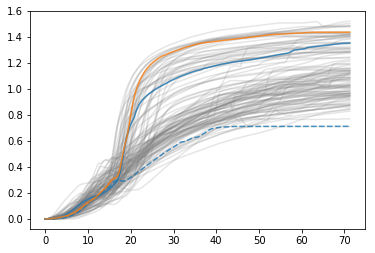

In [24]:
plt.plot(timex[:-1],meddfm[timepts[:-1]].T.values,
         alpha=0.2,color='grey');
plt.plot(timex[:-1], 
         meddfm.T['XL280a'].T[timepts[:-1]].values,
         color='tab:blue',alpha=0.8,linestyle='--')
plt.plot(timex[:-1], 
         meddfm.T['XL280alpha'].T[timepts[:-1]].values,
         color='tab:blue',alpha=0.8,linestyle='-')

plt.plot(timex[:-1], 
         meddfm.T['SS-A837'].T[timepts[:-1]].values,
         color='tab:orange',alpha=0.8,linestyle='-');

In [25]:
len(_431_filt[0])

286

In [26]:
dt = np.max(np.diff(timex))

In [27]:
dt

0.25027777777778226

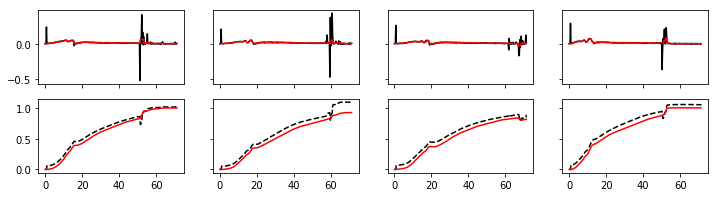

In [28]:
fig,ax = plt.subplots(2,_431.shape[0],figsize=(12,3),sharex=True,sharey='row')

nys = []
for i,k in enumerate(_431):
    
    ndy = _431_filt[i]
    plt.sca(ax[0,i])
    plt.plot(timex[:-1],np.diff(k)/dt,'k');
    plt.plot(timex[:-1],ndy/dt,'r')
    #plt.ylim(-0.001,.05);


    nys.append(np.cumsum(ndy))
    plt.sca(ax[1,i])
    plt.plot(timex,k,'k--')
    plt.plot(timex[:-1], np.cumsum(ndy),'r')
    #plt.plot(timex[:-1], np.cumsum(ndy),'b')

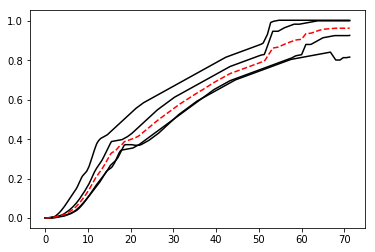

In [29]:
plt.plot(timex[:-1],np.array(nys).T,'k');
plt.plot(timex[:-1],np.median(np.array(nys).T,axis=1),'r--');

In [30]:
k = 51
median_log2_filt = []
for seg in tecan.strain.unique():
    
    _431 = test[(test.strain==seg)][timepts].values
    
    _431_der = np.diff(np.log2(_431.T+1).T,axis=1)/.25
    
    k = 51
    _431_der_filt = np.array([median_filter(y,Kernal=k).T for y in _431_der])
    
    _431_filt = np.array([np.cumsum(y)*.25 for y in _431_der_filt])
    
    median_log2_filt.append(np.median(_431_filt,axis=0))

In [31]:
medlog2y = np.array(median_log2_filt)

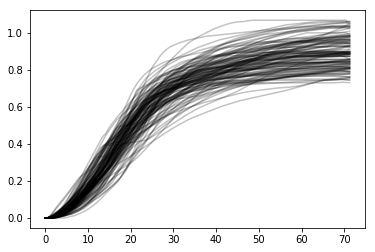

In [32]:
[plt.plot(timex[:-1],y,color='k',alpha=0.24) for y in medlog2y];

In [33]:
_431_der.shape

(4, 286)

In [34]:
from scipy import signal

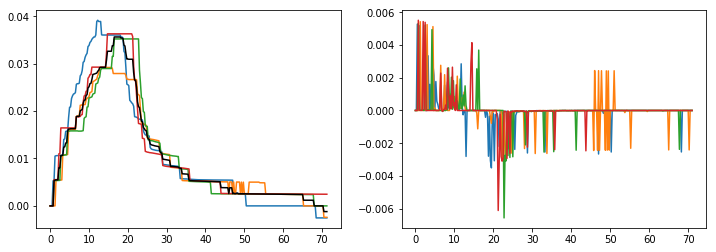

In [35]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
plt.sca(ax[0])
plt.plot(timex[:-1],_431_der_filt.T);
plt.plot(timex[:-1],np.median(_431_der_filt,axis=0),'k');

plt.sca(ax[1])
plt.plot(timex[:-2],np.diff(_431_der_filt).T);
#plt.plot(timex[:-1],np.median(_431_der_filt,axis=0),'k');

In [36]:
median_y = np.median(_431_der_filt,axis=0)

In [37]:
dx = .25

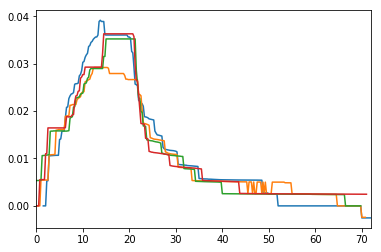

In [38]:
shifts = []
for target in _431_der_filt:

    shift = (np.argmax(signal.correlate(median_y, target)) - len(target)) * dx
    shifts.append(shift)
    plt.plot(timex[:-1] + shift, target);
plt.xlim(0,72);

In [39]:
shifts

[1.5, -0.5, -1.5, -0.25]

In [40]:
df_431_filt = pd.concat([pd.DataFrame(_431_filt[i],index=np.round(np.array(timex[:-1])+s,3))
                         for i,s in enumerate(shifts)],axis=1)
df_431_filt.columns = np.arange(len(_431_filt))

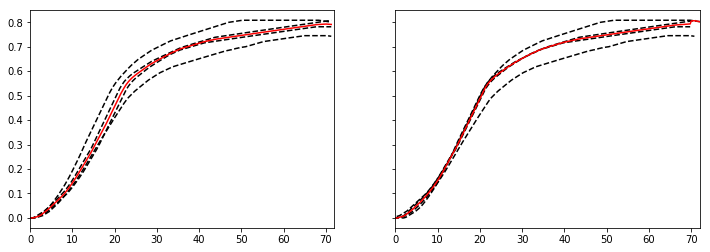

In [41]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
plt.sca(ax[0])
plt.plot(timex[:-1],_431_filt.T,'k--');
plt.plot(timex[:-1], np.median(_431_filt,axis=0), 'r');

old_median = np.median(_431_filt,axis=0)
plt.sca(ax[1])
#[plt.plot(timex[:-1]+s,_431_filt[i],'--') for i,s in enumerate(shifts)]
for i in df_431_filt.columns:

    plt.plot(df_431_filt[i].index, df_431_filt[i].values,'k--')
    
new_median = df_431_filt.median(axis=1)


plt.plot(df_431_filt.index, new_median, 'r')
plt.xlim(0,72);

In [42]:
y = new_median[(new_median.index>=0) & (new_median.index<=72)]
y = pd.Series(old_median,timex[:-1])

In [43]:
from scipy.optimize import curve_fit 

In [44]:
def gompertz(t,A,u,l):
    """Gompertz growth equation"""
    y = A * np.exp(-np.exp(((u*np.exp(1)/A)*(l-t))+1))
    return y

In [45]:
np.max(np.diff(y))/dx

0.035739215309001704

In [46]:
popt_gom, pcov_gom = curve_fit(gompertz, y.index, y.values, method='trf',
                    bounds=(np.array([0,0,0]),
                    np.array([np.max(y.values),
                              np.max(np.diff(y.values)/dx),
                              72])));

In [47]:
popt_gom

array([0.77100426, 0.03183787, 5.6360333 ])

In [48]:
newy = gompertz(timex,*popt_gom)

In [49]:
newy[:5]

array([0.00461974, 0.00532251, 0.00610914, 0.00698325, 0.00795411])

In [54]:
dt

0.25027777777778226

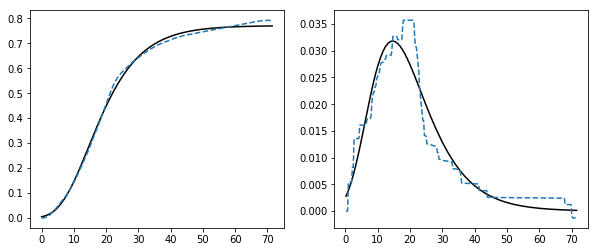

In [55]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
plt.sca(ax[0])
plt.plot(timex,newy,'k');
plt.plot(y.index,y,'--');

plt.sca(ax[1])
plt.plot(timex[1:],np.diff(newy)/dt,'k');
plt.plot(y.index[1:],np.diff(y)/dt,'--');

In [57]:
np.max(np.diff(newy)/dt)

0.031835542614903824

In [ ]:

params = []
yhats = []
errors = []
for i,j in enumerate(temp.iterrows()):
    y = j[1][timeix].apply(float).values
    if np.max(y) < 0.005 or np.round(np.median(y),3) < 0.005:
        popt_gom = np.array([0.0,0.0,72])
    else:
        popt_gom, pcov_gom = curve_fit(gompertz, xt, y, method='trf',
                    bounds=(np.array([0,0,0]),
                    np.array([np.max(y),
                              np.max(np.diff(y)/np.max(np.diff(xt))),
                              72])));

    yhat = gompertz(xt,*popt_gom)
    params.append(popt_gom)
    yhats.append(yhat)
    errors.append(np.sum((yhat-y)**2)/len(y))
    plt.plot(xt,y,color=mycolors[i],label=str(i),linestyle='-.');
    plt.plot(xt,yhats[i],color=mycolors[i],linestyle='-')
    
pardf = pd.DataFrame(params,columns=['A','u','l'])
print(pardf)
print()
print(pardf.median(axis=0).round(3).tolist())
print()
print(pardf.mean(axis=0).round(3).tolist())

plt.legend();
plt.ylabel('OD');
plt.xlabel('Time (hrs)');

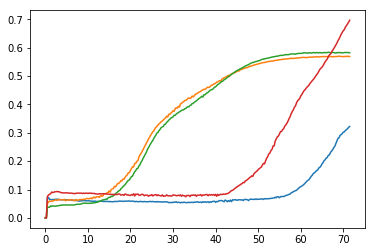

In [361]:
plt.plot(timex,_431.T);

In [9]:
## Set the first two timepoints to zero
tecan.loc[:,timepts[:2]] = 0

In [10]:
## Make the baseline dataframe, this is the first hour and a 15min, post the first half hour
baselinedf = tecan[timepts[2:7]].copy()

In [11]:
## Check shape of baseline dataframe
baselinedf.shape

(5340, 5)

In [12]:
## Set all of those values in baseline near zero to above zero
baselinedf[baselinedf<0] = 0

In [13]:
## Calculate the per sample baseline
baselines = baselinedf.mean(axis=1).values

In [15]:
## Set coloring and background
#plt.style.use(['dark_background','tableau-colorblind10'])
plt.style.use('tableau-colorblind10')

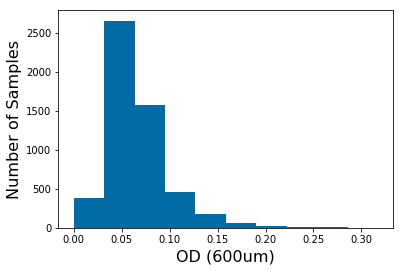

In [16]:
## Plot histogram of baseline values
plt.hist(baselines);
plt.ylabel('Number of Samples',fontsize=16);
plt.xlabel('OD (600um)',fontsize=16);

In [17]:
## Subtract baselines
tecan_tpt = tecan[timepts].T.subtract(baselines).T

In [18]:
## Set values below zero in baselined data to zero
tecan_tpt[tecan_tpt<0] = 0

In [19]:
## Set first 7 time points, 5 in baseline, 2 in dropped values to zero
tecan_tpt[tecan_tpt.columns.tolist()[:7]] = 0.0

In [20]:
## Make filtered dataframe
fdf = pd.concat([tecan[infos],tecan_tpt],axis=1)

In [21]:
## Save dataframe
fdf.to_csv('../FILES/'+file_path.split('/')[-1].split('.csv')[0]+'_baselined.csv')